In [1]:
import numpy as np
import scipy.signal as sps
import sympy as sym 
import scipy.optimize as sopt
%matplotlib inline   
import matplotlib.pyplot as plt


In [2]:
eta_d,eta_q = sym.symbols('eta_d,eta_q')
i_d,i_q,v_dc,i_dc = sym.symbols('i_d,i_q,v_dc,i_dc')
v_sd,v_sq = sym.symbols('v_sd,v_sq')
L,R,C,omega = sym.symbols('L,R,C,omega')
u_d,u_q = sym.symbols('u_d,u_q')
p_ext,i_ext = sym.symbols('p_ext,i_ext')

In [3]:
di_d  = 1/L*(eta_d*v_dc/2 - R*i_d + L*omega*i_q - v_sd)
di_q  = 1/L*(eta_q*v_dc/2 - R*i_q - L*omega*i_d - v_sq)

# p_dc = p_ac = 3/2*(eta_d*v_dc/2*i_d + eta_q*v_dc/2*i_q)
# i_cap = i_dc - p_dc/v_dc
# i_dc - 3/4*(eta_d*i_d + eta_q*i_q)
dv_dc = 1/C*(i_dc - 3/4*(eta_d*i_d + eta_q*i_q ))

f = sym.Matrix([[di_d],[di_q],[dv_dc]])
x = sym.Matrix([[i_d],[i_q],[v_dc]])

F_x = f.jacobian(x)

F_x

Matrix([
[         -R/L,         omega, eta_d/(2*L)],
[       -omega,          -R/L, eta_q/(2*L)],
[-0.75*eta_d/C, -0.75*eta_q/C,           0]])

In [4]:
from sympy.utilities.codegen import codegen

[(c_name, c_code), (h_name, c_header)] = codegen(("f", F_x), "F95", "test", header=False, empty=True)
print(c_code)


subroutine f(C, L, R, eta_d, eta_q, omega, out_2802380343141594273)
implicit none
REAL*8, intent(in) :: C
REAL*8, intent(in) :: L
REAL*8, intent(in) :: R
REAL*8, intent(in) :: eta_d
REAL*8, intent(in) :: eta_q
REAL*8, intent(in) :: omega
REAL*8, intent(out), dimension(1:3, 1:3) :: out_2802380343141594273

out_2802380343141594273(1, 1) = -R/L
out_2802380343141594273(2, 1) = -omega
out_2802380343141594273(3, 1) = -0.75d0*eta_d/C
out_2802380343141594273(1, 2) = omega
out_2802380343141594273(2, 2) = -R/L
out_2802380343141594273(3, 2) = -0.75d0*eta_q/C
out_2802380343141594273(1, 3) = (1.0d0/2.0d0)*eta_d/L
out_2802380343141594273(2, 3) = (1.0d0/2.0d0)*eta_q/L
out_2802380343141594273(3, 3) = 0

end subroutine



In [5]:

from sympy.utilities.lambdify import lambdify


func = lambdify(x, f,'numpy') # returns a numpy-ready function

print(func(1,2,3))

[[(2*L*omega - R + 3*eta_d/2 - v_sd)/L]
 [(-L*omega - 2*R + 3*eta_q/2 - v_sq)/L]
 [(-0.75*eta_d - 1.5*eta_q + i_dc)/C]]


## $\sf i_d$-$\sf i_q$ mode

In [6]:
params = {'L':2.5e-3,
          'R':1.0,
          'C':2000.0e-6,
          'omega':2.0*np.pi*50,
          'v_sq':-np.sqrt(2./3)*400.0,
          'v_sd':0.0,
          'v_dc':800.0
         }

# sym.pretty_print(f.subs(params))

u = sym.Matrix([[i_d],[i_q],[eta_d],[eta_q]])

f_ss = lambdify(u, f[0:2,0].subs(params),'numpy') # returns a numpy-ready function

def eqs_ss(x):
    
    i_d = -20.0
    i_q = 0.0
    
    eta_d, eta_q = x[0],x[1]
    
    return f_ss(i_d, i_q,eta_d,eta_q )

sol = sopt.broyden1(eqs_ss, [0,1], f_tol=1e-8)

print('eta_d = {:2.3f}, eta_q = {:2.3f}'.format(sol[0],sol[1]))
print('[{:2.6f}, {:2.6f}]'.format(sol[0],sol[1]))

eta_d = -0.050, eta_q = -0.856
[-0.050000, -0.855766]


In [7]:
sym.solve(di_d*L+R*i_d-u_d, eta_d)
sym.solve(di_q*L+R*i_q-u_q, eta_q)

[2*(L*i_d*omega + u_q + v_sq)/v_dc]

## $\sf p$-$\sf q$ mode

In [8]:
params = {'L':2.5e-3,
          'R':1.0,
          'C':2000.0e-6,
          'omega':2.0*np.pi*50,
          'v_sq':np.sqrt(2./3)*400.0,
          'v_sd':0.0,
          'v_dc':800.0
         }

p_ref,q_ref = sym.symbols('p_ref,q_ref')

eq_p = 3/2*(v_sd*i_d + v_sq*i_q) - p_ref
eq_q = 3/2*(v_sd*i_q - v_sq*i_d) - q_ref

f_pq =  sym.Matrix([[eq_p],[eq_q]]) 
# sym.pretty_print(f.subs(params))

u = sym.Matrix([[p_ref],[q_ref],[i_d],[i_q],[eta_d],[eta_q]])

f_ss = lambdify(u, f[0:2,0].col_join(f_pq).subs(params),'numpy') # returns a numpy-ready function

def eqs_ss(x):
    
    p_ref = 15.0e3
    q_ref = 0.0e3
    
    i_d, i_q = x[0],x[1]
    eta_d, eta_q = x[2],x[3]
    
    return f_ss(p_ref,q_ref, i_d, i_q,eta_d,eta_q )

sol = sopt.broyden1(eqs_ss, [0,1,2,3], f_tol=1e-8)

print('eta_d = {:2.3f}, eta_q = {:2.3f}'.format(sol[2],sol[3]))

eta_d = -0.060, eta_q = 0.893


In [9]:
sym.solve((eq_p,eq_q),i_d,i_q)

{i_d: 0.666666666666667*(p_ref*v_sd - q_ref*v_sq)/(v_sd**2 + v_sq**2),
 i_q: 0.666666666666667*(p_ref*v_sq + q_ref*v_sd)/(v_sd**2 + v_sq**2)}

In [10]:
800*2000e-6/0.1

16.0

## $\sf i_d$-$\sf v_{dc}$ mode

In [11]:
params = {'L':2.5e-3,
          'R':0.2,
          'C':2000.0e-6,
          'omega':2.0*np.pi*50,
          'v_sq':np.sqrt(2./3)*400.0,
          'v_sd':0.0,
          'i_d':0.0,
          'v_dc':700.0
          }

params = {'L':2.5e-3,
          'R':0.2,
          'C':2000.0e-6,
          'omega':2.0*np.pi*50,
          'v_sq':np.sqrt(2./3)*400.0,
          'v_sd':0.0,
          'i_d':-30.0,
          'v_dc':700.0,
          'i_dc':0.0,
          }

# sym.pretty_print(f.subs(params))

u = sym.Matrix([[i_q],[eta_d],[eta_q]])

f_ss = lambdify(u, f.subs(params),'numpy') # returns a numpy-ready function


def eqs_ss(x):
    
   
    eta_d, eta_q, i_q = x[0],x[1],x[2]
   
    return f_ss(i_q, eta_d,eta_q )


    
sol = sopt.broyden1(eqs_ss, [0,1,10],f_tol=1e-8)



print('eta_d = {:2.3f}, eta_q = {:2.3f}, i_q = {:2.3f}'.format(sol[0],sol[1],sol[2]))

params.update({'eta_d':sol[0],'eta_q':sol[1],'i_q':sol[2]})

p = 3/2*(v_sd*i_d + v_sq*i_q) 
q = 3/2*(v_sd*i_q - v_sq*i_d) 


f_p= lambdify([], p.subs(params),'numpy') # returns a numpy-ready function
f_q= lambdify([], q.subs(params),'numpy') # returns a numpy-ready function

print('p = {:2.3f} W, q = {:2.3f} var'.format(f_p(),f_q()))

u = sym.Matrix([[eta_d],[eta_q]])
h = sym.Matrix([[i_d]])

F_x = f.jacobian(x)
f_A = lambdify([], F_x.subs(params),'numpy')
F_u = f.jacobian(u)
f_B = lambdify([], F_u.subs(params),'numpy')
H_x = h.jacobian(x)
f_C = lambdify([], H_x.subs(params),'numpy')
H_u = h.jacobian(u)
f_D = lambdify([], H_u.subs(params),'numpy')

A = f_A()
B = f_B()
C = f_C()
D = f_D()
eig, evec = np.linalg.eig(A)

eta_d = -0.016, eta_q = 0.866, i_q = -0.551
p = -270.091 W, q = 14696.938 var


## $\sf i_d$-$\sf v_{dc}$ mode with $\sf p_{dc}^{ext}$

⎡                   η_d⋅v_dc        ⎤
⎢ L⋅i_q⋅ω - R⋅i_d + ──────── - v_sd ⎥
⎢                      2            ⎥
⎢ ───────────────────────────────── ⎥
⎢                 L                 ⎥
⎢                                   ⎥
⎢                   η_q⋅v_dc        ⎥
⎢-L⋅i_d⋅ω - R⋅i_q + ──────── - v_sq ⎥
⎢                      2            ⎥
⎢────────────────────────────────── ⎥
⎢                L                  ⎥
⎢                                   ⎥
⎢                               pₑₓₜ⎥
⎢-0.75⋅η_d⋅i_d - 0.75⋅η_q⋅i_q + ────⎥
⎢                               v_dc⎥
⎢───────────────────────────────────⎥
⎣                 C                 ⎦


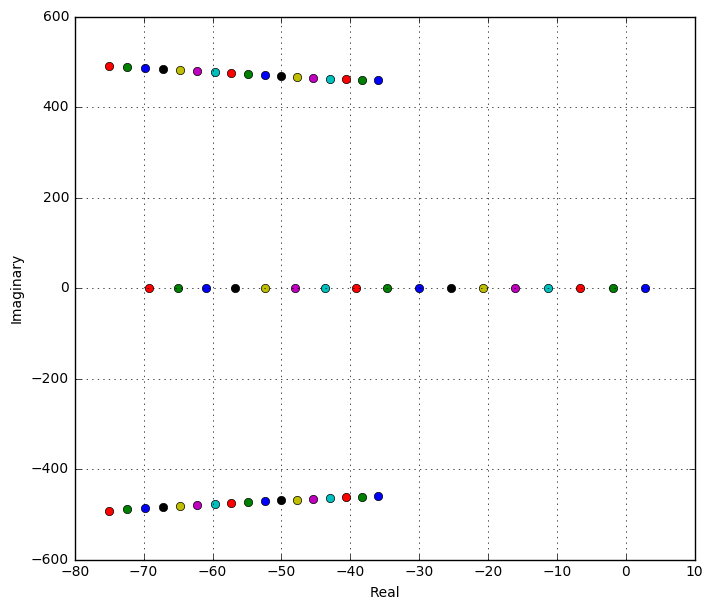

In [19]:
params = {'L':1100e-6,
          'R':0.1,
          'C':2000.0e-6,
          'omega':2.0*np.pi*50,
          'v_sq':np.sqrt(2./3)*400.0,
          'v_sd':0.0,
          'i_d':0.0,
          'v_dc':730.0,
         # 'p_ext':-50.0e3
          }

# sym.pretty_print(f.subs(params))
u = sym.Matrix([[i_q],[eta_d],[eta_q],[p_ext]])

i_ext = p_ext/v_dc

f_dc = f.subs(i_dc,i_ext)


sym.pretty_print(f_dc)


#params['p_ext'] = p_ext_N 
f_ss = sym.lambdify(u, f_dc.subs(params),'numpy') # returns a numpy-ready function


fig = plt.figure(figsize=(8,7))
ax  = fig.add_subplot(1,1,1)

class eqs_ss:
    
    def __init__(self):
        
        self.p_ext = 0.0e3
    
    def update(self, x):  

        eta_d, eta_q, i_q = x[0],x[1],x[2]

        return f_ss(i_q, eta_d,eta_q, self.p_ext )


eq = eqs_ss()

pows = np.arange(-120e3,50e3,10e3)
eigs_real = []
eigs_imag = []

for p_ext_N in pows:
    
    eq.p_ext = p_ext_N


    sol = sopt.broyden1(eq.update, [0,.5,p_ext_N/700],f_tol=1e-8)

    #print('eta_d = {:2.3f}, eta_q = {:2.3f}, i_q = {:2.3f}'.format(sol[0],sol[1],sol[2]))

    params.update({'eta_d':sol[0],'eta_q':sol[1],'i_q':sol[2]})

    p = 3/2*(v_sd*i_d + v_sq*i_q) 
    q = 3/2*(v_sd*i_q - v_sq*i_d) 

    f_p= sym.lambdify([], p.subs(params),'numpy') # returns a numpy-ready function
    f_q= sym.lambdify([], q.subs(params),'numpy') # returns a numpy-ready function

    #print('p = {:2.3f} W, q = {:2.3f} var'.format(f_p(),f_q()))

    u = sym.Matrix([[eta_d],[eta_q]])
    h = sym.Matrix([[i_d]])

    F_x = f_dc.jacobian(x)
    f_A = sym.lambdify([], F_x.subs(params).subs({'p_ext':p_ext_N}),'numpy')
    A = f_A()
    eig, evec = np.linalg.eig(A)
    eigs_real += [eig.real[0]]
    eigs_imag += [eig.imag[0]]
    ax.plot(eig.real,eig.imag, 'o')
'''
    F_u = f.jacobian(u)
    f_B = lambdify([], F_u.subs(params),'numpy')
    H_x = h.jacobian(x)
    f_C = lambdify([], H_x.subs(params),'numpy')
    H_u = h.jacobian(u)
    f_D = lambdify([], H_u.subs(params),'numpy')
   
    B = f_B()
    C = f_C()
    D = f_D()
    
'''
ax.grid(True)
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')




plt.show()
fig.savefig('rlocus_100kva.svg')

In [13]:
pows

array([-90000., -80000., -70000., -60000., -50000., -40000., -30000.,
       -20000., -10000.,      0.,  10000.,  20000.,  30000.,  40000.])

In [14]:
pows

array([-90000., -80000., -70000., -60000., -50000., -40000., -30000.,
       -20000., -10000.,      0.,  10000.,  20000.,  30000.,  40000.])

In [15]:
F_x = f_dc.jacobian(x)
sym.pretty_print(F_x)
f_A = lambdify([], F_x.subs(params),'numpy')
A = f_A()
eig, evec = np.linalg.eig(A)

⎡   -R                     η_d  ⎤
⎢   ───          ω         ───  ⎥
⎢    L                     2⋅L  ⎥
⎢                               ⎥
⎢               -R         η_q  ⎥
⎢    -ω         ───        ───  ⎥
⎢                L         2⋅L  ⎥
⎢                               ⎥
⎢-0.75⋅η_d   -0.75⋅η_q    -pₑₓₜ ⎥
⎢──────────  ──────────  ───────⎥
⎢    C           C             2⎥
⎣                        C⋅v_dc ⎦


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
A

In [ ]:
G = sps.ss2tf(A,B,C,D)
G

In [ ]:
H_x

In [ ]:
np.linalg.eig(A)

In [ ]:
C

In [ ]:
from sympy.utilities.codegen import codegen



In [ ]:
codegen(("f", f),'c')

In [ ]:
f

In [ ]:
from sympy.utilities.codegen import codegen,FCodeGen

params = {'L':1400e-6,
          'R':0.1,
          'C':2000.0e-6,
          'omega':2.0*np.pi*50,
          'v_sq':np.sqrt(2./3)*400.0,
          'v_sd':0.0,
          }

[(c_name, c_code), (h_name, c_header)] = codegen(f, "C", "test", header=True, empty=False)
print(c_code)

In [ ]:
codegen(f, "C", header=False, empty=False)

In [ ]:
f